In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

for dirname, subdirs, filenames in os.walk('/kaggle/input'):
    # Sum of lifes in dir
    # Print folder name and file count
    file_count = len(filenames)
    level = dirname.replace('/kaggle/input', '').count(os.sep)
    indent = '  ' * level
    folder_name = os.path.basename(dirname) if dirname != '/kaggle/input' else 'ROOT (/kaggle/input)'
    if file_count > 0:
        print(f"{indent} {folder_name}: {file_count} files")
    else:
        print(f"{indent} {folder_name}: (empty)")
    # Print subdirectories if any
    if subdirs:
        print(f"{indent}  Subfolders: {subdirs}")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 ROOT (/kaggle/input): (empty)
  Subfolders: ['crop-pests-dataset']
   crop-pests-dataset: 1 files
    Subfolders: ['valid', 'test', 'train']
     valid: (empty)
      Subfolders: ['labels', 'images']
       labels: 1095 files
       images: 1095 files
     test: (empty)
      Subfolders: ['labels', 'images']
       labels: 546 files
       images: 546 files
     train: (empty)
      Subfolders: ['labels', 'images']
       labels: 11502 files
       images: 11502 files


In [2]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch 
from collections import Counter
import cv2
import random
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm

base_dir = "/kaggle/input/crop-pests-dataset"


TRAIN Set:
  Images: 11502
  Labels: 11502
  Unique pest types: 13

VALID Set:
  Images: 1095
  Labels: 1095
  Unique pest types: 12

TEST Set:
  Images: 546
  Labels: 546
  Unique pest types: 12


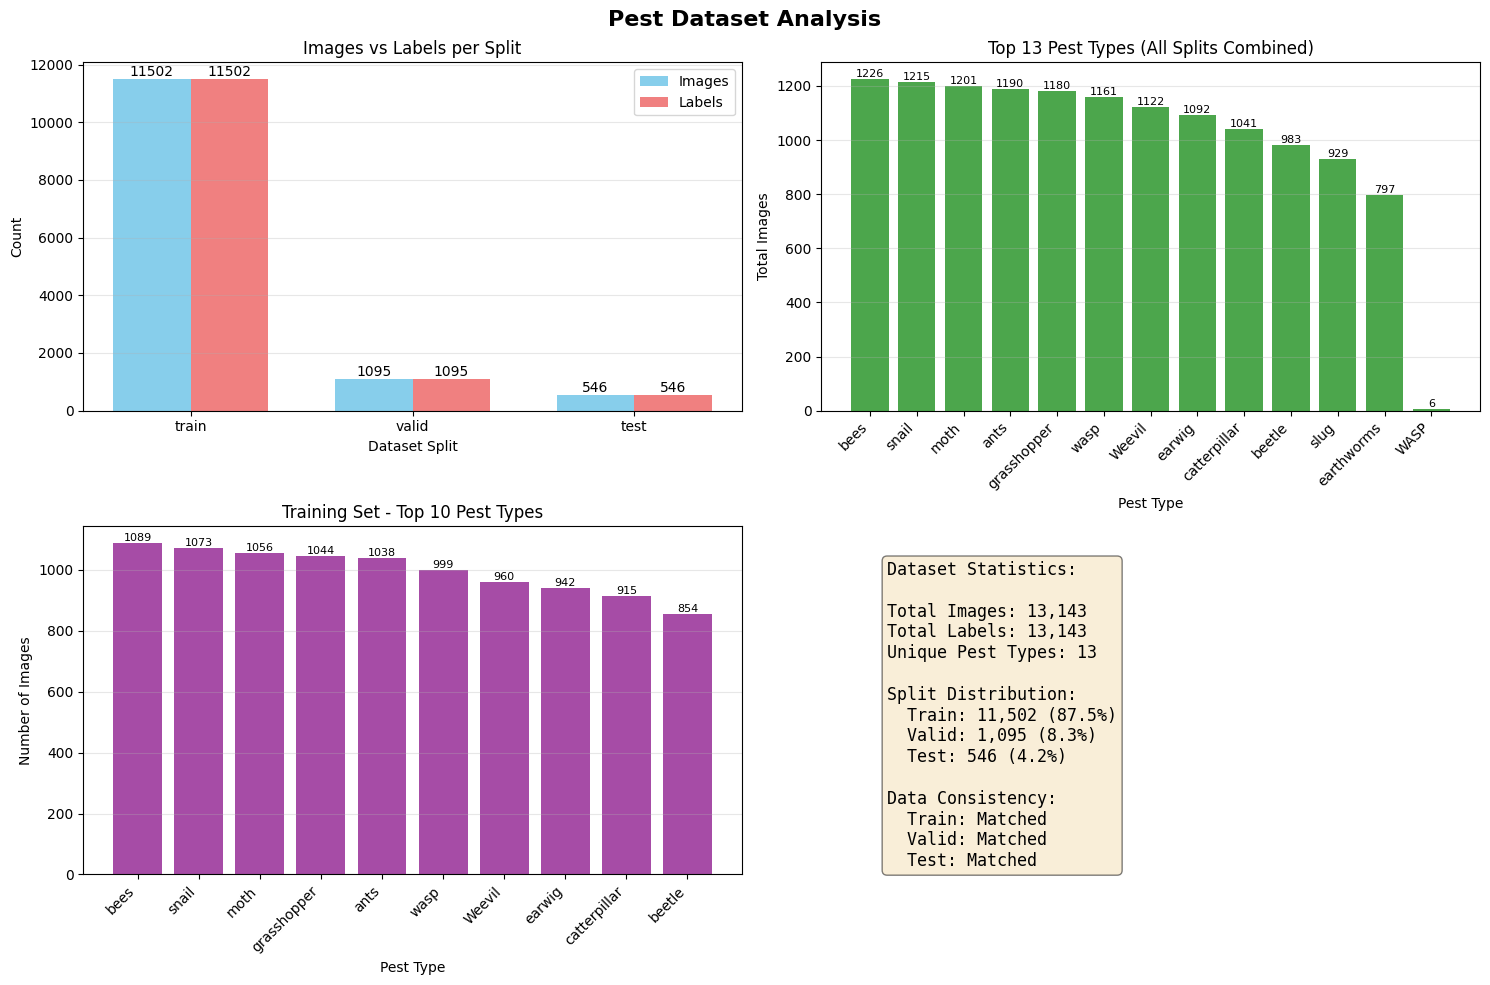

Exploring TRAIN split: Found 13 unique pest types


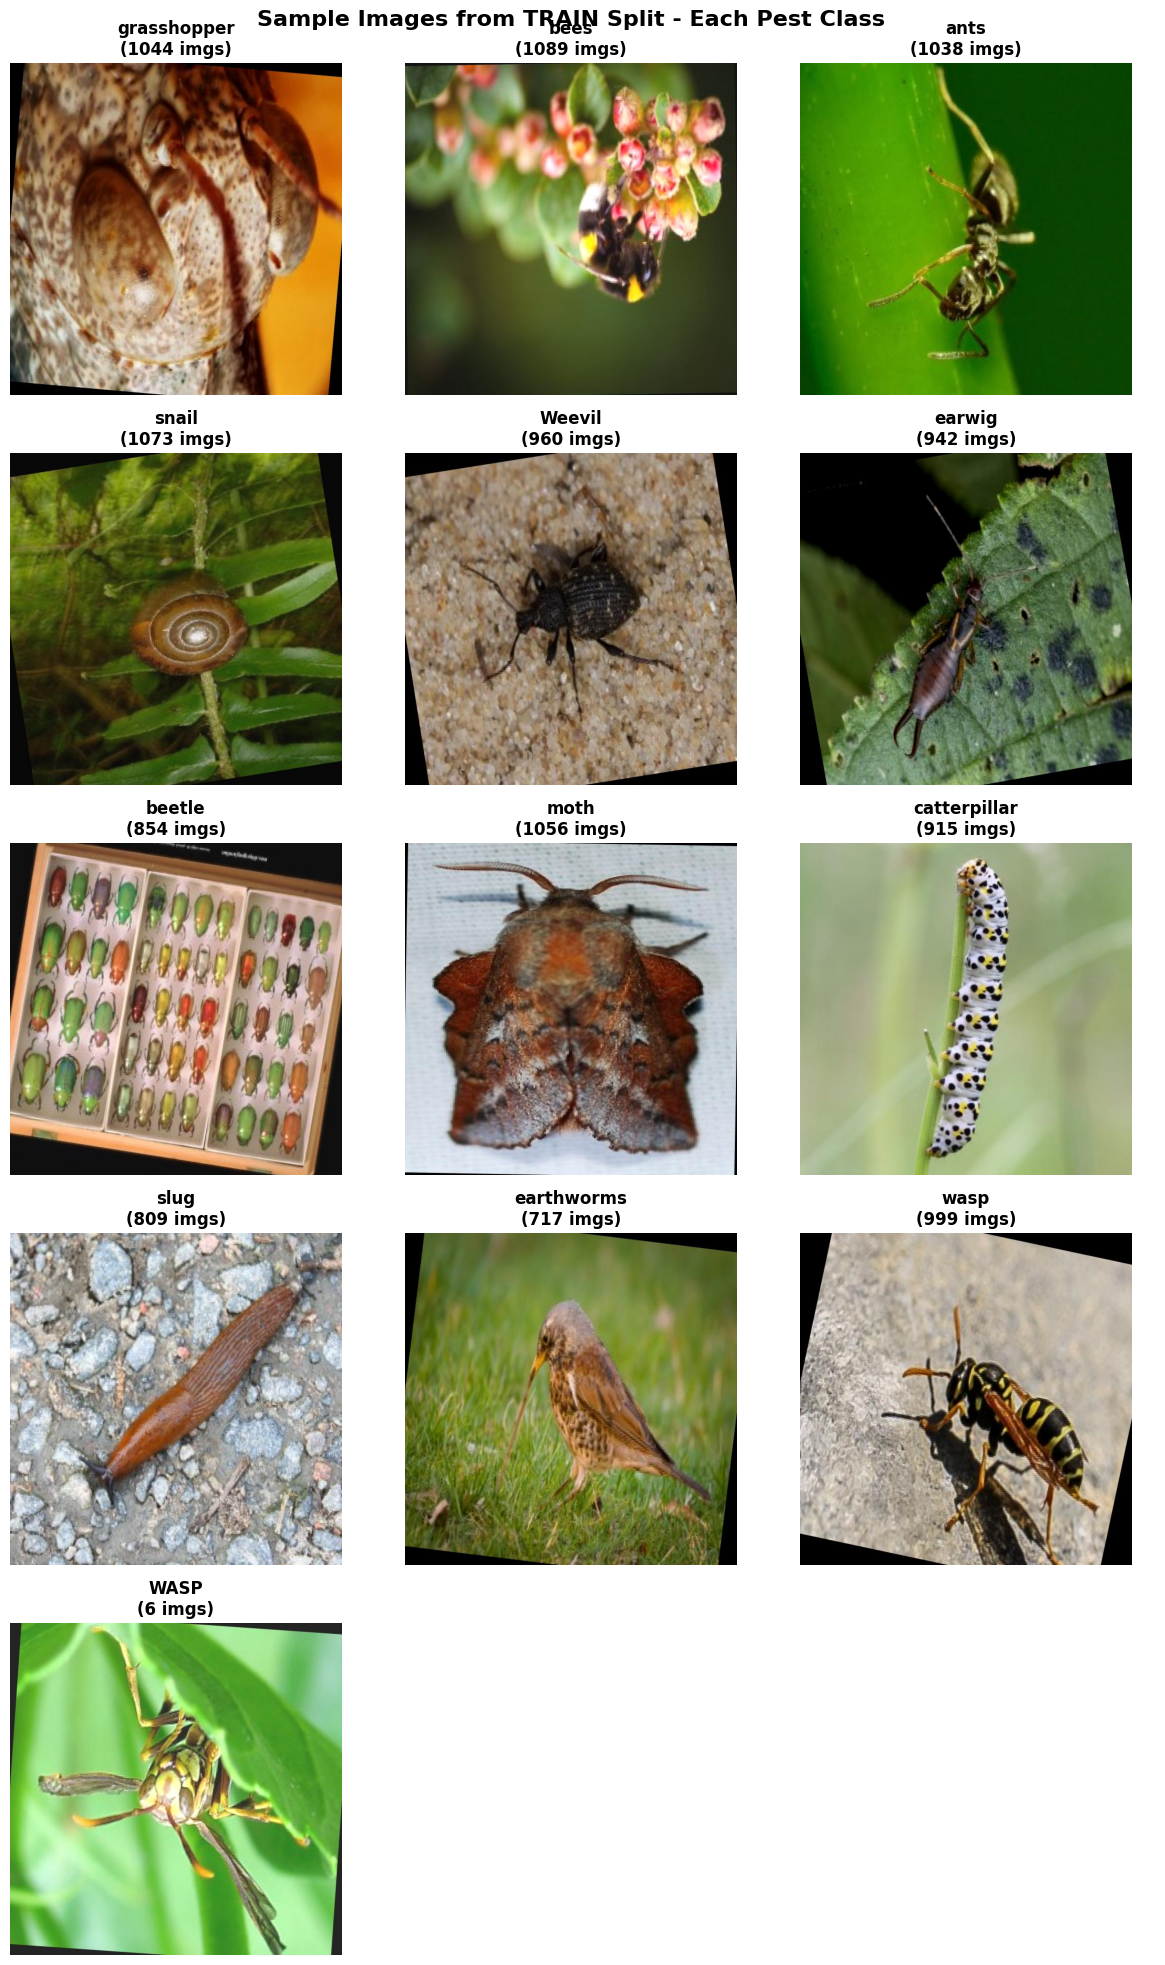


TRAIN Split Statistics:
  bees           : 1089 images
  snail          : 1073 images
  moth           : 1056 images
  grasshopper    : 1044 images
  ants           : 1038 images
  wasp           :  999 images
  Weevil         :  960 images
  earwig         :  942 images
  catterpillar   :  915 images
  beetle         :  854 images
  slug           :  809 images
  earthworms     :  717 images
  WASP           :    6 images

Pest data struct


In [3]:
def analyze_pest_dataset(base_dir="/kaggle/input/crop-pests-dataset"):
    """
    Analyze pest dataset structure and create visualizations
    Optimized for time complexity and storage
    """
    results = {}
    
    for folder in ['train', 'valid', 'test']:
        folder_path = os.path.join(base_dir, folder)
        if not os.path.exists(folder_path):
            continue
            
        images_path = os.path.join(folder_path, "images")
        labels_path = os.path.join(folder_path, "labels")
        
        # Single pass to get all data
        images = os.listdir(images_path) if os.path.exists(images_path) else []
        labels = os.listdir(labels_path) if os.path.exists(labels_path) else []
        
        # Extract pest types efficiently in one pass
        pest_counts = Counter()
        for img_name in images:
            # Simplified extraction - removed redundant splits
            pest_type = ''.join(c for c in img_name.split('_')[0].split('-')[0].split('.')[0] if not c.isdigit())
            if pest_type:
                pest_counts[pest_type] += 1
        
        results[folder] = {
            'total_images': len(images),
            'total_labels': len(labels),
            'pest_distribution': dict(pest_counts)
        }
    
    return results

def visualize_dataset(results):
    """
    Create bar graphs for dataset analysis
    Optimized layout and processing
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Pest Dataset Analysis', fontsize=16, fontweight='bold')
    
    # Dataset distribution
    ax1 = axes[0, 0]
    folders = list(results.keys())
    image_counts = [results[f]['total_images'] for f in folders]
    label_counts = [results[f]['total_labels'] for f in folders]
    
    x = np.arange(len(folders))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, image_counts, width, label='Images', color='skyblue')
    bars2 = ax1.bar(x + width/2, label_counts, width, label='Labels', color='lightcoral')
    
    ax1.set_xlabel('Dataset Split')
    ax1.set_ylabel('Count')
    ax1.set_title('Images vs Labels per Split')
    ax1.set_xticks(x)
    ax1.set_xticklabels(folders)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom')
    
    # Combined pest distribution
    ax2 = axes[0, 1]
    all_pests = Counter()
    for folder_data in results.values():
        all_pests.update(folder_data['pest_distribution'])
    
    if all_pests:
        # Get top 15 pests efficiently
        top_pests = all_pests.most_common(15)
        pest_names, pest_values = zip(*top_pests) if top_pests else ([], [])
        
        bars = ax2.bar(range(len(pest_names)), pest_values, color='green', alpha=0.7)
        ax2.set_xlabel('Pest Type')
        ax2.set_ylabel('Total Images')
        ax2.set_title(f'Top {len(pest_names)} Pest Types (All Splits Combined)')
        ax2.set_xticks(range(len(pest_names)))
        ax2.set_xticklabels(pest_names, rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Training set distribution
    ax3 = axes[1, 0]
    if 'train' in results and results['train']['pest_distribution']:
        train_pests = Counter(results['train']['pest_distribution']).most_common(10)
        if train_pests:
            pest_names, pest_values = zip(*train_pests)
            
            bars = ax3.bar(range(len(pest_names)), pest_values, color='purple', alpha=0.7)
            ax3.set_xlabel('Pest Type')
            ax3.set_ylabel('Number of Images')
            ax3.set_title('Training Set - Top 10 Pest Types')
            ax3.set_xticks(range(len(pest_names)))
            ax3.set_xticklabels(pest_names, rotation=45, ha='right')
            ax3.grid(axis='y', alpha=0.3)
            
            for bar in bars:
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Statistics summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculate statistics efficiently
    total_images = sum(r['total_images'] for r in results.values())
    total_labels = sum(r['total_labels'] for r in results.values())
    
    stats_lines = [
        "Dataset Statistics:\n",
        f"Total Images: {total_images:,}",
        f"Total Labels: {total_labels:,}",
        f"Unique Pest Types: {len(all_pests)}\n",
        "Split Distribution:"
    ]
    
    for folder, data in results.items():
        percentage = (data['total_images'] / total_images * 100) if total_images > 0 else 0
        stats_lines.append(f"  {folder.capitalize()}: {data['total_images']:,} ({percentage:.1f}%)")
    
    stats_lines.append("\nData Consistency:")
    for folder, data in results.items():
        match = "Matched" if data['total_images'] == data['total_labels'] else "Mismatch"
        stats_lines.append(f"  {folder.capitalize()}: {match}")
    
    stats_text = '\n'.join(stats_lines)
    ax4.text(0.1, 0.9, stats_text, fontsize=12, verticalalignment='top',
            fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    return fig

def explore_samples(split='train', base_dir="/kaggle/input/crop-pests-dataset", num_cols=4):
    """
    Display random samples from each pest class
    Optimized for memory and processing efficiency
    """
    if split not in ['train', 'valid', 'test']:
        print(f"Error: split must be 'train', 'valid', or 'test'. Got '{split}'")
        return
    
    images_path = os.path.join(base_dir, split, "images")
    if not os.path.exists(images_path):
        print(f"Error: Path doesn't exist: {images_path}")
        return
    
    # Single pass to group images
    pest_groups = {}
    for img_name in os.listdir(images_path):
        pest_type = ''.join(c for c in img_name.split('_')[0].split('-')[0].split('.')[0] if not c.isdigit())
        if pest_type:
            if pest_type not in pest_groups:
                pest_groups[pest_type] = []
            pest_groups[pest_type].append(img_name)
    
    print(f"Exploring {split.upper()} split: Found {len(pest_groups)} unique pest types")
    
    # Calculate grid dimensions
    num_pests = len(pest_groups)
    num_rows = (num_pests + num_cols - 1) // num_cols
    
    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))
    
    # Ensure axes is always 2D array
    if num_rows == 1 and num_cols == 1:
        axes = np.array([[axes]])
    elif num_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.ravel()
    
    # Display samples
    for idx, (pest_type, images) in enumerate(pest_groups.items()):
        if idx >= len(axes_flat):
            break
            
        sample_img = random.choice(images)
        img_path = os.path.join(images_path, sample_img)
        
        img = Image.open(img_path)
        axes_flat[idx].imshow(img)
        axes_flat[idx].set_title(f'{pest_type}\n({len(images)} imgs)', 
                                fontsize=12, fontweight='bold')
        axes_flat[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(pest_groups), len(axes_flat)):
        axes_flat[idx].axis('off')
    
    plt.suptitle(f'Sample Images from {split.upper()} Split - Each Pest Class', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics (sorted by count)
    print(f"\n{split.upper()} Split Statistics:")
    for pest_type, images in sorted(pest_groups.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"  {pest_type:15s}: {len(images):4d} images")


if __name__ == "__main__":
    try:
        # Analyze dataset -- Function 
        results = analyze_pest_dataset()
        
        # Print results
        for folder, data in results.items():
            print(f"\n{folder.upper()} Set:")
            print(f"  Images: {data['total_images']}")
            print(f"  Labels: {data['total_labels']}")
            print(f"  Unique pest types: {len(data['pest_distribution'])}")
        
        # Create visualizations
        fig = visualize_dataset(results)
        
        # [train,test,valid, num_cols=] -- function 
        explore_samples(split='train',num_cols= 3)
        
        # Success message
        print("\n" + "="*50)
        print("Pest data struct")
        print("="*50)
        
    except Exception as e:
        print(f"\n✗ ERROR: Pipeline failed - {str(e)}")
        raise

## Handling imbalance classes

In [4]:

def check_duplicate_classes(base_dir="/kaggle/input/crop-pests-dataset"):
    """
    Find classes that might be duplicates (different cases)
    """
    all_pest_names = set()
    
    for split in ['train', 'valid', 'test']:
        images_path = os.path.join(base_dir, split, "images")
        for img_name in os.listdir(images_path):
            pest_type = img_name.split('_')[0].split('-')[0].split('.')[0]
            pest_type = ''.join([c for c in pest_type if not c.isdigit()])
            if pest_type:
                all_pest_names.add(pest_type)
    print("All unique pest names found:")
    for name in sorted(all_pest_names):
        print(f"  - {name}")
    # Check for case-insensitive duplicates
    print("\nPotential duplicates (case differences):")
    pest_lower = {}
    for pest in all_pest_names:
        lower = pest.lower()
        if lower in pest_lower:
            print(f"  DUPLICATE: '{pest_lower[lower]}' and '{pest}'")
        else:
            pest_lower[lower] = pest


In [5]:
check_duplicate_classes()

All unique pest names found:
  - WASP
  - Weevil
  - ants
  - bees
  - beetle
  - catterpillar
  - earthworms
  - earwig
  - grasshopper
  - moth
  - slug
  - snail
  - wasp

Potential duplicates (case differences):
  DUPLICATE: 'WASP' and 'wasp'


In [6]:
def get_merged_class_counts(base_dir="/kaggle/input/crop-pests-dataset"):
    """
    Get class counts with WASP/wasp merged
    """
    class_counts = {}
    
    for split in ['train', 'valid', 'test']:
        class_counts[split] = {}
        images_path = os.path.join(base_dir, split, "images")
        for img_name in os.listdir(images_path):
            # Extract and normalize pest name
            pest_type = img_name.split('_')[0].split('-')[0].split('.')[0]
            pest_type = ''.join([c for c in pest_type if not c.isdigit()])
            # NORMALIZE TO LOWERCASE to merge WASP/wasp
            pest_type = pest_type.lower()
            if pest_type:
                class_counts[split][pest_type] = class_counts[split].get(pest_type, 0) + 1
    # Show training distribution
    print("\nMERGED Training Distribution:\n\n")
    sorted_train = sorted(class_counts['train'].items(), key=lambda x: x[1], reverse=True)
    for pest, count in sorted_train:
        print(f"  {pest:15s}: {count:4d} images")
    print(f"\nTotal: {sum(class_counts['train'].values())} training images")
    print(f"Classes: {len(class_counts['train'])} unique pests")
    
    return class_counts

class_counts = get_merged_class_counts()


MERGED Training Distribution:


  bees           : 1089 images
  snail          : 1073 images
  moth           : 1056 images
  grasshopper    : 1044 images
  ants           : 1038 images
  wasp           : 1005 images
  weevil         :  960 images
  earwig         :  942 images
  catterpillar   :  915 images
  beetle         :  854 images
  slug           :  809 images
  earthworms     :  717 images

Total: 11502 training images
Classes: 12 unique pests


## Make these as one

In [7]:
def calculate_augmentation_needs(class_counts, target=1000, max_limit=1100):
    """
    Calculate how many augmented images we need for each class
    """
    train_counts = class_counts['train'] 
    augmentation_plan = {}
    print("\n\nAUGMENTATION:\n\n")    
    for pest, current_count in sorted(train_counts.items(), key=lambda x: x[1]):
        if current_count < target:
            # Calculate how many augmented images needed
            min_needed = target - current_count
            max_allowed = max_limit - current_count
            # 1050 as target images for each class( lt 1000 images )
            target_augment = 1050 - current_count
            # How many augmentations per original image?
            augment_factor = target_augment / current_count
            augmentation_plan[pest] = {
                'current': current_count,
                'target': 1050,
                'needed': target_augment,
                'factor': augment_factor
            }
            print(f"{pest:15s}: {current_count:4d} → {1050:4d} (need {target_augment:3d} more, {augment_factor:.2f}x)")
        else:
            print(f"{pest:15s}: {current_count:4d} (no augmentation needed)")
    print("\nAugmentation Overview\n")
    total_current = sum(train_counts.values())
    total_new = sum([p['needed'] for p in augmentation_plan.values()])
    print(f"Current training images: {total_current}")
    print(f"New augmented images: {total_new}")
    print(f"Total after augmentation: {total_current + total_new}")
    
    return augmentation_plan

In [8]:
augmentation_plan = calculate_augmentation_needs(class_counts)



AUGMENTATION:


earthworms     :  717 → 1050 (need 333 more, 0.46x)
slug           :  809 → 1050 (need 241 more, 0.30x)
beetle         :  854 → 1050 (need 196 more, 0.23x)
catterpillar   :  915 → 1050 (need 135 more, 0.15x)
earwig         :  942 → 1050 (need 108 more, 0.11x)
weevil         :  960 → 1050 (need  90 more, 0.09x)
wasp           : 1005 (no augmentation needed)
ants           : 1038 (no augmentation needed)
grasshopper    : 1044 (no augmentation needed)
moth           : 1056 (no augmentation needed)
snail          : 1073 (no augmentation needed)
bees           : 1089 (no augmentation needed)

Augmentation Overview

Current training images: 11502
New augmented images: 1103
Total after augmentation: 12605


In [9]:
def get_class_augmentation(pest_type, augment_factor):
    """
    Return augmentation pipeline based on how much augmentation is needed
    
    Higher factor = needs more augmentation = use more transforms
    """
    if augment_factor > 0.4:  # Heavy (like earthworms: 0.46)
        # Use many transforms for variety
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(
                brightness=0.3,  # Simulate different times of day
                contrast=0.2,    # Different lighting conditions
                saturation=0.2,  # Color variations
                hue=0.1         # Slight color shifts
            ),
            transforms.RandomAffine(
                degrees=15,
                translate=(0.1, 0.1),  # Pest in different positions
                scale=(0.9, 1.1)       # Different distances
            ),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Camera angles
            # Add slight blur sometimes (camera shake)
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2)
        ])
        
    elif augment_factor > 0.2:  # Medium (like beetle: 0.23, slug: 0.30)
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=10, translate=(0.05, 0.05))
        ])
        
    else:  # Light (like weevil: 0.09, catterpillar: 0.15)
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.1, contrast=0.1)
        ])
    
    return transform

In [10]:
print("Augmentation intensity by class:")
print("-" * 40)
for pest, plan in augmentation_plan.items():
    factor = plan['factor']
    if factor > 0.4:
        intensity = "HEAVY"
    elif factor > 0.2:
        intensity = "MEDIUM"
    else:
        intensity = "LIGHT"
    print(f"{pest:15s}: {factor:.2f}x → {intensity} augmentation")

Augmentation intensity by class:
----------------------------------------
earthworms     : 0.46x → HEAVY augmentation
slug           : 0.30x → MEDIUM augmentation
beetle         : 0.23x → MEDIUM augmentation
catterpillar   : 0.15x → LIGHT augmentation
earwig         : 0.11x → LIGHT augmentation
weevil         : 0.09x → LIGHT augmentation


### Augmentation based on factor

In [11]:
def create_balanced_dataloader(base_dir="/kaggle/input/crop-pests-dataset", 
                               split='train', 
                               batch_size=32,
                               augmentation_plan=None):
    """
    Create a balanced dataloader with dynamic augmentation and weighted sampling
    All in one place!
    """   
    class PestDataset(Dataset):  # Now Dataset is imported!
            def __init__(self, root_dir, split, aug_plan):
                self.images_dir = os.path.join(root_dir, split, 'images')
                self.image_files = sorted(os.listdir(self.images_dir))
                self.split = split
                self.aug_plan = aug_plan
                
                # Base transforms
                self.base_transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225])
                ])
            
            def __len__(self):
                return len(self.image_files)
            
            def __getitem__(self, idx):
                img_name = self.image_files[idx]
                image = Image.open(os.path.join(self.images_dir, img_name)).convert('RGB')
                
                # Get pest type
                pest_type = img_name.split('_')[0].split('-')[0].split('.')[0]
                pest_type = ''.join([c for c in pest_type if not c.isdigit()]).lower()
                
                # Apply augmentation if training
                if self.split == 'train' and self.aug_plan and pest_type in self.aug_plan:
                    aug_transform = get_class_augmentation(pest_type, self.aug_plan[pest_type]['factor'])
                    image = aug_transform(image)
                
                image = self.base_transform(image)
                return image, pest_type
        
    # Create dataset
    dataset = PestDataset(base_dir, split, augmentation_plan)
    
    # Create weighted sampler only for training
    if split == 'train' and augmentation_plan:
        weights = []
        for img_name in dataset.image_files:
            pest_type = img_name.split('_')[0].split('-')[0].split('.')[0]
            pest_type = ''.join([c for c in pest_type if not c.isdigit()]).lower()
            
            weight = 1.0 + augmentation_plan.get(pest_type, {}).get('factor', 0)
            weights.append(weight)
        
        sampler = WeightedRandomSampler(weights, len(weights), replacement=True)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
    else:
        # For validation/test, no sampling needed
        return DataLoader(dataset, batch_size=batch_size, shuffle=(split=='train'), num_workers=2)

In [12]:
train_loader = create_balanced_dataloader(split='train', augmentation_plan=augmentation_plan)
valid_loader = create_balanced_dataloader(split='valid')  # No augmentation
test_loader = create_balanced_dataloader(split='test')   # No augmentation

print(f"Train loader: {len(train_loader)} batches")
print(f"Valid loader: {len(valid_loader)} batches")
print(f"Test loader: {len(test_loader)} batches")

Train loader: 360 batches
Valid loader: 35 batches
Test loader: 18 batches


In [13]:
# Let's see what's in a batch
def check_batch(loader, loader_name="Train"):
    """
    Check one batch to see class distribution
    """
    # Get one batch
    images, labels = next(iter(loader))
    
    print(f"\n{loader_name} Batch Check:")
    print(f"  Batch shape: {images.shape}")
    print(f"  Classes in batch: {set(labels)}")
    
    # Count each class
    from collections import Counter
    class_counts = Counter(labels)
    print(f"  Distribution: {dict(class_counts)}")
    
    return images, labels

# Check each loader
train_images, train_labels = check_batch(train_loader, "Train")
valid_images, valid_labels = check_batch(valid_loader, "Valid")
test_images, test_labels = check_batch(test_loader, "Test")


Train Batch Check:
  Batch shape: torch.Size([32, 3, 224, 224])
  Classes in batch: {'grasshopper', 'catterpillar', 'weevil', 'bees', 'earthworms', 'beetle', 'wasp', 'moth', 'snail', 'slug', 'ants'}
  Distribution: {'wasp': 4, 'catterpillar': 1, 'weevil': 3, 'bees': 4, 'ants': 1, 'grasshopper': 2, 'moth': 3, 'snail': 5, 'earthworms': 5, 'slug': 1, 'beetle': 3}

Valid Batch Check:
  Batch shape: torch.Size([32, 3, 224, 224])
  Classes in batch: {'weevil'}
  Distribution: {'weevil': 32}

Test Batch Check:
  Batch shape: torch.Size([32, 3, 224, 224])
  Classes in batch: {'weevil'}
  Distribution: {'weevil': 32}


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training with 3 classes
Training samples: 11502
Validation samples: 1095

Epoch 1/5
------------------------------


Training:   0%|          | 0/360 [00:01<?, ?it/s]


NameError: name 'pest_to_idx' is not defined